In [1]:
# Thrust vs CuPy Benchmark Notebook
# Import required libraries
import numpy as np
import cupy as cp
import ctypes
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from ctypes import c_int, c_long, c_float, c_double, c_void_p, POINTER, byref

# Global variables
_thrust_lib = None

def load_thrust_library(library_path='./libthrust_fortran.so'):
    """
    Load the Thrust Fortran shared library.
    
    Parameters:
    -----------
    library_path : str
        Path to the compiled shared library
        
    Returns:
    --------
    ctypes.CDLL
        Loaded library object
    """
    global _thrust_lib
    
    if _thrust_lib is not None:
        return _thrust_lib
    
    if not os.path.exists(library_path):
        raise FileNotFoundError(f"Library not found: {library_path}")
    
    try:
        _thrust_lib = ctypes.CDLL(library_path)
        
        # Set function return types
        _thrust_lib.sort_float_wrapper.restype = None
        _thrust_lib.sort_double_wrapper.restype = None
        _thrust_lib.sort_int_wrapper.restype = None
        
        _thrust_lib.reduce_float_wrapper.restype = c_float
        _thrust_lib.reduce_double_wrapper.restype = c_double
        _thrust_lib.reduce_int_wrapper.restype = c_int
        
        _thrust_lib.transform_float_wrapper.restype = None
        _thrust_lib.transform_double_wrapper.restype = None
        _thrust_lib.transform_int_wrapper.restype = None
        
        print(f"Successfully loaded Thrust library from {library_path}")
        return _thrust_lib
    except Exception as e:
        raise RuntimeError(f"Failed to load library: {e}")

def run_performance_benchmark(sizes=[10000, 100000, 1000000], num_trials=3, dtype=np.float32):
    """
    Run performance benchmark comparing CuPy and Thrust.
    
    Parameters:
    -----------
    sizes : list
        List of array sizes to benchmark
    num_trials : int
        Number of trials to run for each test
    dtype : numpy.dtype
        Data type to test (np.float32, np.float64, or np.int32)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing benchmark results
    """
    if _thrust_lib is None:
        raise RuntimeError("Thrust library not loaded. Call load_thrust_library() first.")
    
    # Map numpy dtypes to ctypes
    if dtype == np.float32:
        ctype = c_float
        sort_func = _thrust_lib.sort_float_wrapper
        reduce_func = _thrust_lib.reduce_float_wrapper
        transform_func = _thrust_lib.transform_float_wrapper
    elif dtype == np.float64:
        ctype = c_double
        sort_func = _thrust_lib.sort_double_wrapper
        reduce_func = _thrust_lib.reduce_double_wrapper
        transform_func = _thrust_lib.transform_double_wrapper
    elif dtype == np.int32:
        ctype = c_int
        sort_func = _thrust_lib.sort_int_wrapper
        reduce_func = _thrust_lib.reduce_int_wrapper
        transform_func = _thrust_lib.transform_int_wrapper
    else:
        raise ValueError(f"Unsupported dtype: {dtype}")
    
    results = []
    
    for size in sizes:
        print(f"Testing array size: {size}")
        
        for trial in range(num_trials):
            # Generate random data
            if np.issubdtype(dtype, np.integer):
                cpu_data = np.random.randint(0, 1000, size=size).astype(dtype)
            else:
                cpu_data = np.random.random(size).astype(dtype)
            
            # -------- CuPy benchmarks --------
            cp_data = cp.asarray(cpu_data)
            
            # CuPy sort
            cp.cuda.runtime.deviceSynchronize()
            start_time = time.time()
            cp_sorted = cp.sort(cp.copy(cp_data))
            cp.cuda.runtime.deviceSynchronize()
            cupy_sort_time = time.time() - start_time
            
            # CuPy reduce
            cp.cuda.runtime.deviceSynchronize()
            start_time = time.time()
            cp_sum = cp.sum(cp_data)
            cp.cuda.runtime.deviceSynchronize()
            cupy_reduce_time = time.time() - start_time
            
            # CuPy transform
            cp.cuda.runtime.deviceSynchronize()
            start_time = time.time()
            cp_squared = cp_data * cp_data
            cp.cuda.runtime.deviceSynchronize()
            cupy_transform_time = time.time() - start_time
            
            # -------- Thrust benchmarks --------
            # We need a device copy of data
            gpu_data = cp.asarray(cpu_data)
            
            # Need to pass device pointer to Thrust
            device_ptr = gpu_data.data.ptr
            
            # Sort benchmark
            start_time = time.time()
            sort_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
            cp.cuda.runtime.deviceSynchronize()
            thrust_sort_time = time.time() - start_time
            
            # Reset data for next test
            gpu_data = cp.asarray(cpu_data)
            device_ptr = gpu_data.data.ptr
            
            # Reduce benchmark
            start_time = time.time()
            thrust_sum = reduce_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
            cp.cuda.runtime.deviceSynchronize()
            thrust_reduce_time = time.time() - start_time
            
            # Reset data for next test
            gpu_data = cp.asarray(cpu_data)
            device_ptr = gpu_data.data.ptr
            
            # Transform benchmark
            start_time = time.time()
            transform_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
            cp.cuda.runtime.deviceSynchronize()
            thrust_transform_time = time.time() - start_time
            
            # Store results
            results.append({
                'size': size,
                'trial': trial + 1,
                'dtype': str(dtype).split('.')[-1],
                'cupy_sort_time': cupy_sort_time,
                'thrust_sort_time': thrust_sort_time,
                'cupy_reduce_time': cupy_reduce_time,
                'thrust_reduce_time': thrust_reduce_time,
                'cupy_transform_time': cupy_transform_time,
                'thrust_transform_time': thrust_transform_time,
                'cupy_sum': float(cp_sum),
                'thrust_sum': float(thrust_sum) if hasattr(thrust_sum, 'value') else float(thrust_sum)
            })
    
    return pd.DataFrame(results)

def verify_accuracy(size=1000000, dtype=np.float32):
    """
    Verify that Thrust and CuPy produce the same results.
    
    Parameters:
    -----------
    size : int
        Size of the test array
    dtype : numpy.dtype
        Data type to test
        
    Returns:
    --------
    dict
        Dictionary containing accuracy results
    """
    if _thrust_lib is None:
        raise RuntimeError("Thrust library not loaded. Call load_thrust_library() first.")
    
    # Map numpy dtypes to ctypes
    if dtype == np.float32:
        ctype = c_float
        sort_func = _thrust_lib.sort_float_wrapper
        reduce_func = _thrust_lib.reduce_float_wrapper
        transform_func = _thrust_lib.transform_float_wrapper
    elif dtype == np.float64:
        ctype = c_double
        sort_func = _thrust_lib.sort_double_wrapper
        reduce_func = _thrust_lib.reduce_double_wrapper
        transform_func = _thrust_lib.transform_double_wrapper
    elif dtype == np.int32:
        ctype = c_int
        sort_func = _thrust_lib.sort_int_wrapper
        reduce_func = _thrust_lib.reduce_int_wrapper
        transform_func = _thrust_lib.transform_int_wrapper
    else:
        raise ValueError(f"Unsupported dtype: {dtype}")
    
    # Generate random data
    if np.issubdtype(dtype, np.integer):
        cpu_data = np.random.randint(0, 1000, size=size).astype(dtype)
    else:
        cpu_data = np.random.random(size).astype(dtype)
    
    results = {}
    
    # -------- Sorting accuracy test --------
    # CuPy sort
    cp_data = cp.asarray(cpu_data)
    cp_sorted = cp.sort(cp.copy(cp_data)).get()
    
    # Thrust sort
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    sort_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_sorted = gpu_data.get()
    
    # Check if results match
    if np.issubdtype(dtype, np.floating):
        sort_match = np.allclose(cp_sorted, thrust_sorted, rtol=1e-5, atol=1e-8)
        sort_max_diff = np.max(np.abs(cp_sorted - thrust_sorted))
        sort_avg_diff = np.mean(np.abs(cp_sorted - thrust_sorted))
    else:
        sort_match = np.array_equal(cp_sorted, thrust_sorted)
        sort_max_diff = 0 if sort_match else np.max(np.abs(cp_sorted - thrust_sorted))
        sort_avg_diff = 0 if sort_match else np.mean(np.abs(cp_sorted - thrust_sorted))
    
    results['sort'] = {
        'match': sort_match,
        'max_diff': sort_max_diff,
        'avg_diff': sort_avg_diff
    }
    
    # -------- Reduction accuracy test --------
    # CuPy reduce
    cp_data = cp.asarray(cpu_data)
    cp_sum = float(cp.sum(cp_data))
    
    # Thrust reduce
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    thrust_sum = reduce_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_sum = thrust_sum if not hasattr(thrust_sum, 'value') else thrust_sum.value
    
    # Check if results match
    if np.issubdtype(dtype, np.floating):
        reduce_match = abs(cp_sum - thrust_sum) < 1e-5 * abs(cp_sum)
        reduce_rel_diff = abs(cp_sum - thrust_sum) / abs(cp_sum) if cp_sum != 0 else 0
    else:
        reduce_match = cp_sum == thrust_sum
        reduce_rel_diff = 0 if reduce_match else abs(cp_sum - thrust_sum) / abs(cp_sum) if cp_sum != 0 else 0
    
    results['reduce'] = {
        'match': reduce_match,
        'cupy_result': cp_sum,
        'thrust_result': thrust_sum,
        'rel_diff': reduce_rel_diff
    }
    
    # -------- Transform accuracy test --------
    # CuPy transform
    cp_data = cp.asarray(cpu_data)
    cp_squared = (cp_data * cp_data).get()
    
    # Thrust transform
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    transform_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_squared = gpu_data.get()
    
    # Check if results match
    if np.issubdtype(dtype, np.floating):
        transform_match = np.allclose(cp_squared, thrust_squared, rtol=1e-5, atol=1e-8)
        transform_max_diff = np.max(np.abs(cp_squared - thrust_squared))
        transform_avg_diff = np.mean(np.abs(cp_squared - thrust_squared))
    else:
        transform_match = np.array_equal(cp_squared, thrust_squared)
        transform_max_diff = 0 if transform_match else np.max(np.abs(cp_squared - thrust_squared))
        transform_avg_diff = 0 if transform_match else np.mean(np.abs(cp_squared - thrust_squared))
    
    results['transform'] = {
        'match': transform_match,
        'max_diff': transform_max_diff,
        'avg_diff': transform_avg_diff
    }
    
    return results

def plot_benchmark_results(df):
    """
    Create visualizations of benchmark results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing benchmark results from run_performance_benchmark()
    
    Returns:
    --------
    tuple
        Tuple of matplotlib figure objects
    """
    # Calculate mean times by size
    summary = df.groupby(['size', 'dtype']).agg({
        'cupy_sort_time': 'mean',
        'thrust_sort_time': 'mean',
        'cupy_reduce_time': 'mean',
        'thrust_reduce_time': 'mean',
        'cupy_transform_time': 'mean',
        'thrust_transform_time': 'mean'
    }).reset_index()
    
    # Create figures
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    
    # Plot for each dtype
    dtypes = df['dtype'].unique()
    markers = ['o', 's', '^', 'D']
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, dtype in enumerate(dtypes):
        dtype_data = summary[summary['dtype'] == dtype]
        
        # Sort comparison
        ax1.plot(dtype_data['size'], dtype_data['cupy_sort_time'], 
                marker=markers[i % len(markers)], linestyle='-', color=colors[i % len(colors)],
                label=f'CuPy {dtype}')
        ax1.plot(dtype_data['size'], dtype_data['thrust_sort_time'], 
                marker=markers[i % len(markers)], linestyle='--', color=colors[i % len(colors)],
                label=f'Thrust {dtype}')
        
        # Reduce comparison
        ax2.plot(dtype_data['size'], dtype_data['cupy_reduce_time'], 
                marker=markers[i % len(markers)], linestyle='-', color=colors[i % len(colors)],
                label=f'CuPy {dtype}')
        ax2.plot(dtype_data['size'], dtype_data['thrust_reduce_time'], 
                marker=markers[i % len(markers)], linestyle='--', color=colors[i % len(colors)],
                label=f'Thrust {dtype}')
        
        # Transform comparison
        ax3.plot(dtype_data['size'], dtype_data['cupy_transform_time'], 
                marker=markers[i % len(markers)], linestyle='-', color=colors[i % len(colors)],
                label=f'CuPy {dtype}')
        ax3.plot(dtype_data['size'], dtype_data['thrust_transform_time'], 
                marker=markers[i % len(markers)], linestyle='--', color=colors[i % len(colors)],
                label=f'Thrust {dtype}')
    
    # Configure axes
    for ax, title in zip([ax1, ax2, ax3], 
                         ['Sort Performance', 'Reduce Performance', 'Transform Performance']):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Array Size')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'{title}: CuPy vs Thrust')
        ax.legend()
        ax.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    return fig1, fig2, fig3

def calculate_speedups(df):
    """
    Calculate speedup ratios between CuPy and Thrust.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing benchmark results
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing speedup ratios
    """
    # Calculate mean times by size and dtype
    summary = df.groupby(['size', 'dtype']).agg({
        'cupy_sort_time': 'mean',
        'thrust_sort_time': 'mean',
        'cupy_reduce_time': 'mean',
        'thrust_reduce_time': 'mean',
        'cupy_transform_time': 'mean',
        'thrust_transform_time': 'mean'
    }).reset_index()
    
    # Calculate speedups (ratio of CuPy time to Thrust time)
    summary['sort_speedup'] = summary['cupy_sort_time'] / summary['thrust_sort_time']
    summary['reduce_speedup'] = summary['cupy_reduce_time'] / summary['thrust_reduce_time']
    summary['transform_speedup'] = summary['cupy_transform_time'] / summary['thrust_transform_time']
    
    # Values > 1 mean Thrust is faster, < 1 mean CuPy is faster
    return summary[['size', 'dtype', 'sort_speedup', 'reduce_speedup', 'transform_speedup']]

def plot_speedups(speedup_df):
    """
    Plot speedup ratios between CuPy and Thrust.
    
    Parameters:
    -----------
    speedup_df : pandas.DataFrame
        DataFrame containing speedup ratios from calculate_speedups()
        
    Returns:
    --------
    matplotlib.figure.Figure
        Matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    operations = ['sort_speedup', 'reduce_speedup', 'transform_speedup']
    op_labels = ['Sort', 'Reduce', 'Transform']
    markers = ['o', 's', '^']
    
    dtypes = speedup_df['dtype'].unique()
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, dtype in enumerate(dtypes):
        dtype_data = speedup_df[speedup_df['dtype'] == dtype]
        
        for j, (op, label) in enumerate(zip(operations, op_labels)):
            ax.plot(dtype_data['size'], dtype_data[op], 
                    marker=markers[j % len(markers)], 
                    color=colors[i % len(colors)],
                    label=f'{label} ({dtype})')
    
    # Add a horizontal line at y=1 (equal performance)
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.7)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Array Size')
    ax.set_ylabel('Speedup Ratio (CuPy time / Thrust time)')
    ax.set_title('Performance Comparison: Values > 1 mean Thrust is faster')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    return fig

Successfully loaded Thrust library from ./libthrust_fortran.so

Running benchmarks for float32...
Testing array size: 10000
Testing array size: 50000
Testing array size: 100000
Testing array size: 500000
Testing array size: 1000000
Testing array size: 5000000
Testing array size: 10000000
Testing array size: 50000000

Speedup ratios (CuPy time / Thrust time):
Values > 1 mean Thrust is faster, < 1 mean CuPy is faster
       size      dtype  sort_speedup  reduce_speedup  transform_speedup
0     10000  float32'>     21.106347      169.030391          14.349593
1     50000  float32'>      0.591424        0.870110           0.541833
2    100000  float32'>      1.131181        0.636535           0.412698
3    500000  float32'>      0.801763        0.279131           0.100100
4   1000000  float32'>      0.522055        0.156517           0.146018
5   5000000  float32'>      0.278414        0.066341           0.037734
6  10000000  float32'>      0.247266        0.066488           0.062889
7  50

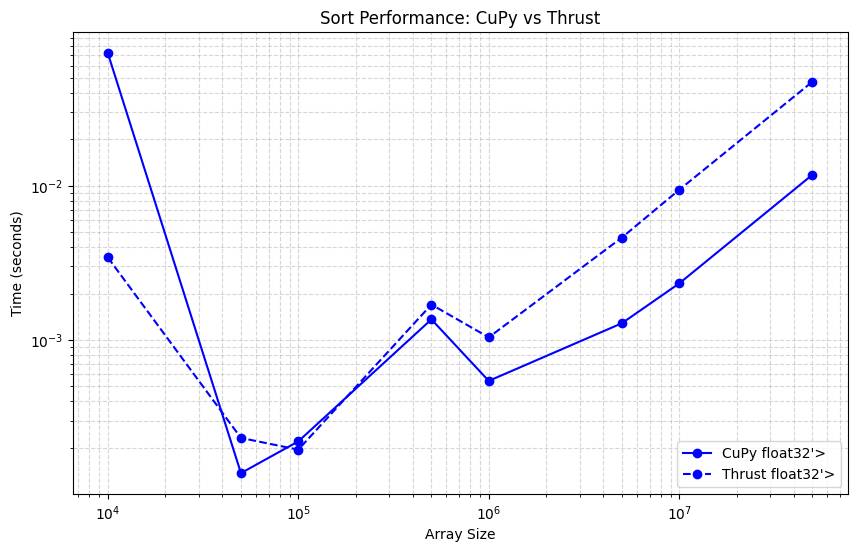

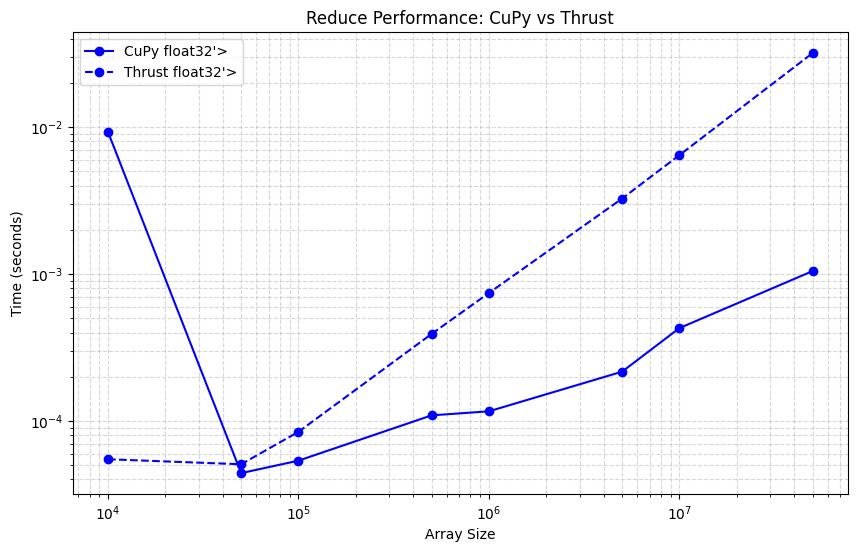

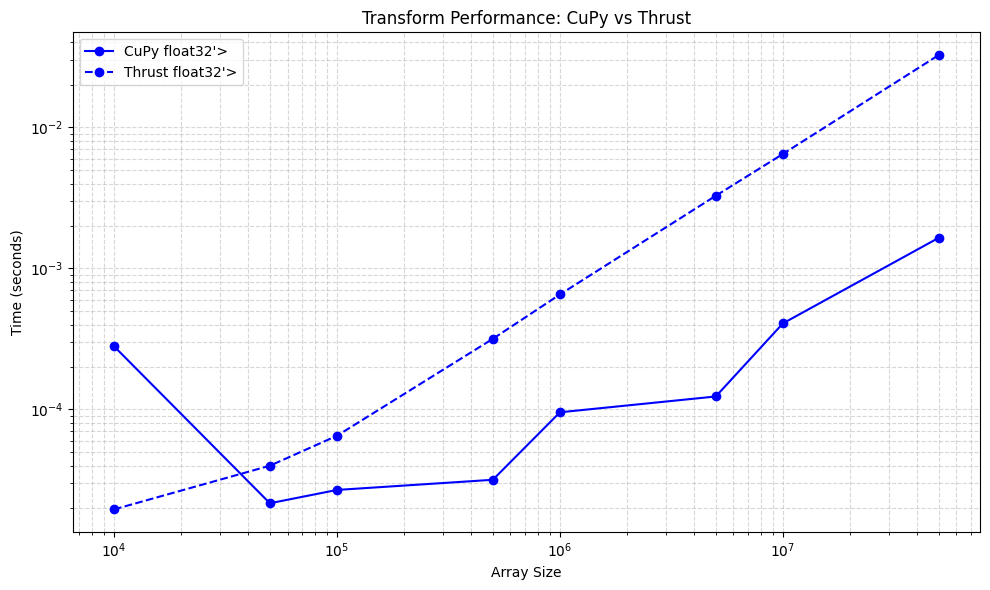

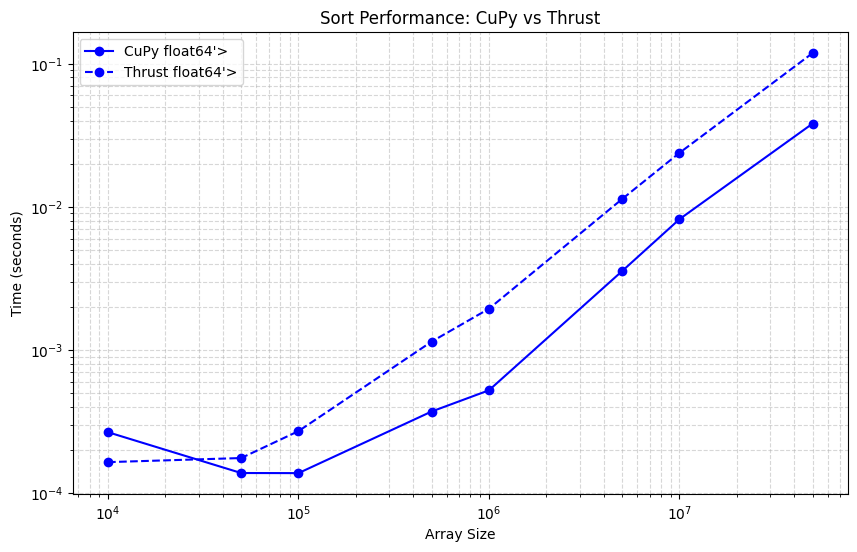

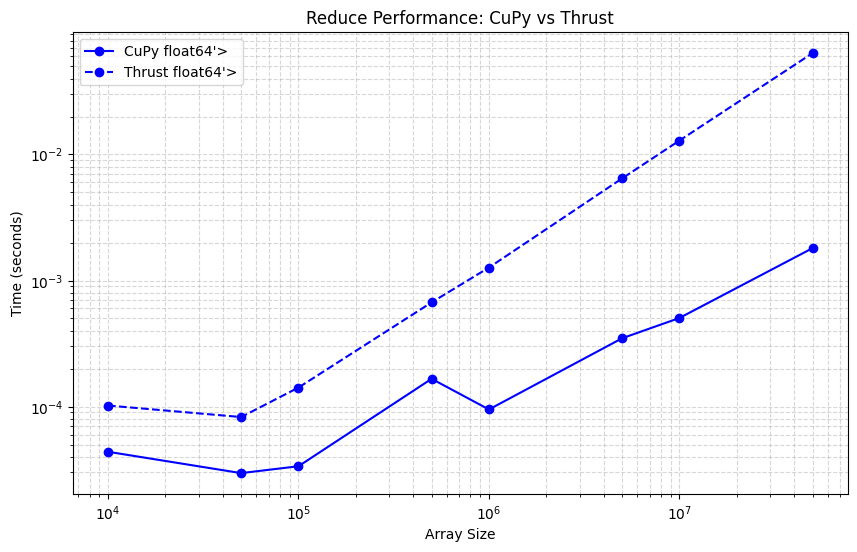

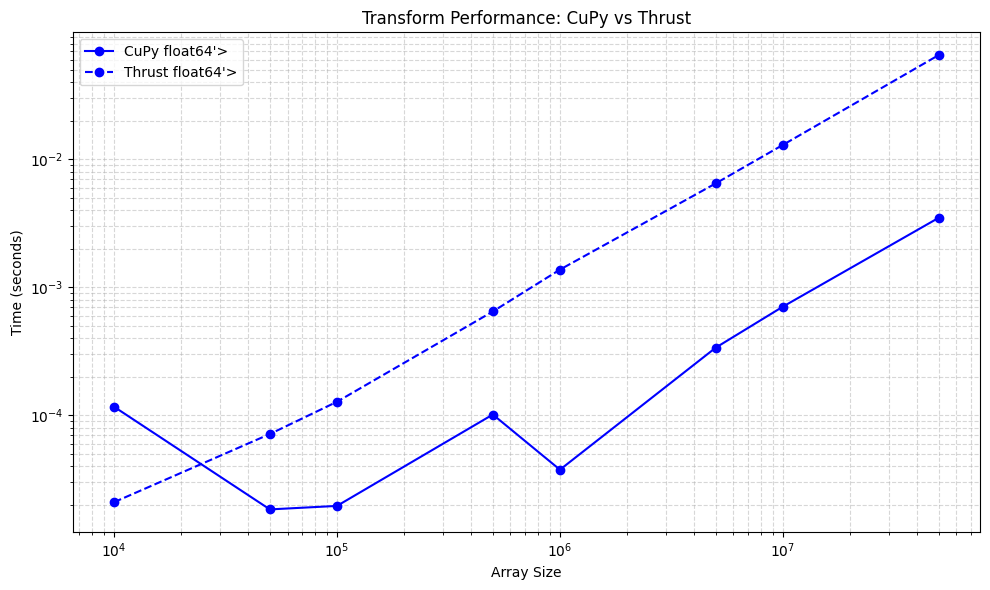

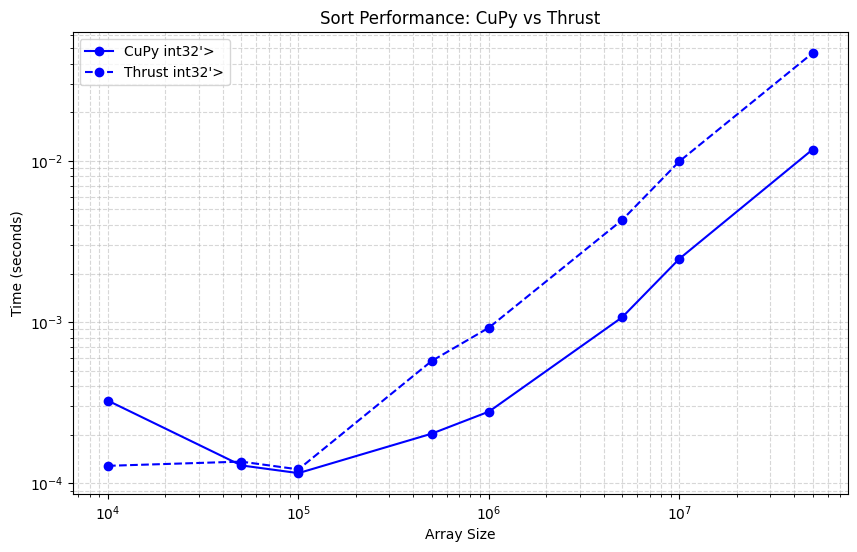

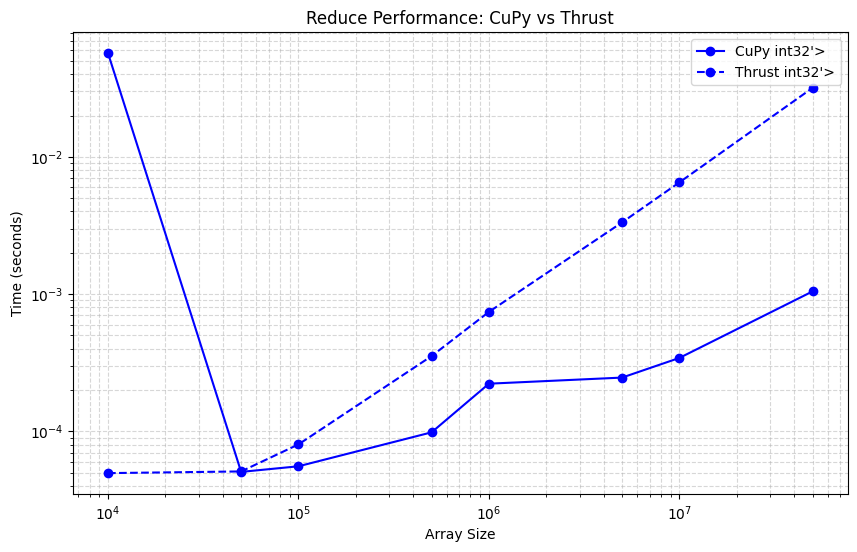

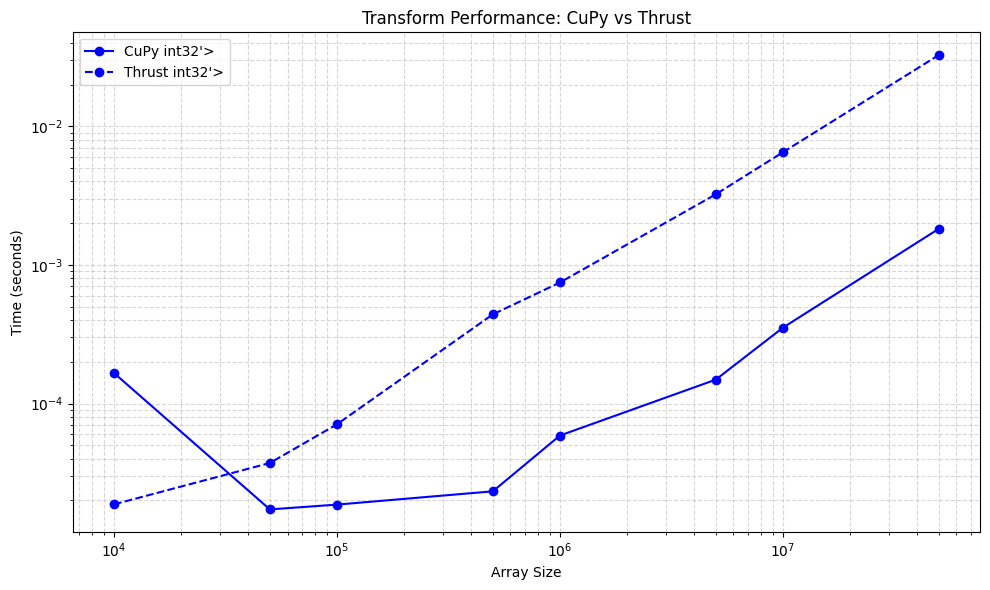

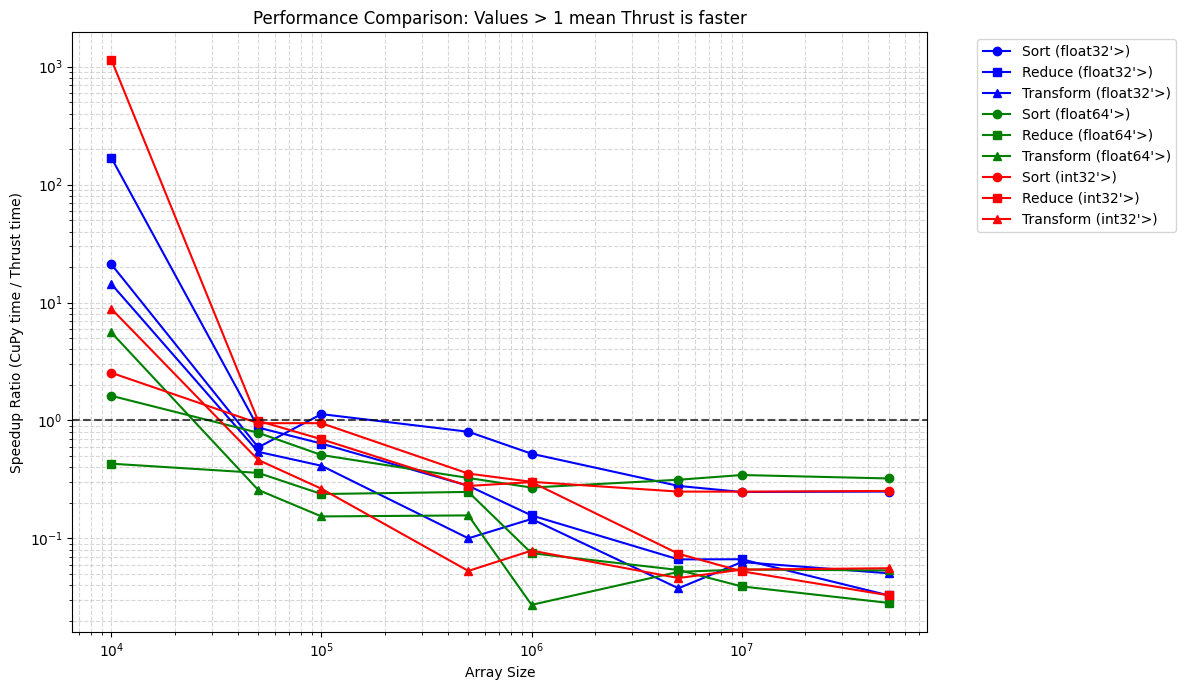

In [2]:
# Load the Thrust library (change the path if your library is located elsewhere)
lib = load_thrust_library('./libthrust_fortran.so')

# Set up the benchmark parameters
sizes = [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000]  # Array sizes to test
num_trials = 3  # Number of trials for each test
dtypes = [np.float32, np.float64, np.int32]  # Data types to test

# Dictionary to store results for all data types
all_results = {}

# Run the benchmarks for each data type
for dtype in dtypes:
    print(f"\nRunning benchmarks for {dtype.__name__}...")
    
    # Run performance benchmarks
    results = run_performance_benchmark(
        sizes=sizes, 
        num_trials=num_trials,
        dtype=dtype
    )
    
    all_results[dtype.__name__] = results
    
    # Plot results for this data type
    figs = plot_benchmark_results(results)
    
    # Calculate speedups
    speedups = calculate_speedups(results)
    print("\nSpeedup ratios (CuPy time / Thrust time):")
    print("Values > 1 mean Thrust is faster, < 1 mean CuPy is faster")
    print(speedups)
    
    # Verify accuracy (using the smallest size for faster execution)
    print(f"\nVerifying accuracy for {dtype.__name__}...")
    accuracy = verify_accuracy(size=sizes[0], dtype=dtype)
    
    print("Accuracy Results:")
    for op, res in accuracy.items():
        print(f"{op.capitalize()}: {'MATCH' if res['match'] else 'MISMATCH'}")
        if not res['match']:
            if op in ['sort', 'transform']:
                print(f"  Max diff: {res['max_diff']:.2e}, Avg diff: {res['avg_diff']:.2e}")
            else:
                print(f"  CuPy: {res['cupy_result']}, Thrust: {res['thrust_result']}")
                print(f"  Relative diff: {res['rel_diff']:.2e}")

# Combine all results for comparison
all_df = pd.concat(all_results.values())

# Create combined speedup plot
all_speedups = calculate_speedups(all_df)
speedup_fig = plot_speedups(all_speedups)

# Display summary statistics
print("\n== SUMMARY STATISTICS ==")
for dtype, df in all_results.items():
    print(f"\nData type: {dtype}")
    avg_times = df.groupby('size').agg({
        'cupy_sort_time': 'mean',
        'thrust_sort_time': 'mean',
        'cupy_reduce_time': 'mean',
        'thrust_reduce_time': 'mean',
        'cupy_transform_time': 'mean',
        'thrust_transform_time': 'mean'
    })
    print(avg_times)

In [3]:
# Create a function to display and compare the first n elements
def compare_outputs(dtype=np.float32, size=1000, n_display=20, seed=42):
    """
    Compare the first n elements of outputs from CuPy and Thrust operations.
    
    Parameters:
    -----------
    dtype : numpy.dtype
        Data type to test
    size : int
        Size of the test array
    n_display : int
        Number of elements to display
    seed : int
        Random seed for reproducibility
    """
    if _thrust_lib is None:
        raise RuntimeError("Thrust library not loaded. Call load_thrust_library() first.")
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Map numpy dtypes to ctypes
    if dtype == np.float32:
        ctype = c_float
        sort_func = _thrust_lib.sort_float_wrapper
        reduce_func = _thrust_lib.reduce_float_wrapper
        transform_func = _thrust_lib.transform_float_wrapper
    elif dtype == np.float64:
        ctype = c_double
        sort_func = _thrust_lib.sort_double_wrapper
        reduce_func = _thrust_lib.reduce_double_wrapper
        transform_func = _thrust_lib.transform_double_wrapper
    elif dtype == np.int32:
        ctype = c_int
        sort_func = _thrust_lib.sort_int_wrapper
        reduce_func = _thrust_lib.reduce_int_wrapper
        transform_func = _thrust_lib.transform_int_wrapper
    else:
        raise ValueError(f"Unsupported dtype: {dtype}")
    
    # Generate random data
    if np.issubdtype(dtype, np.integer):
        cpu_data = np.random.randint(0, 1000, size=size).astype(dtype)
    else:
        cpu_data = np.random.random(size).astype(dtype)
    
    print(f"Data type: {dtype.__name__}, Array size: {size}, Displaying first {n_display} elements\n")
    
    # Display original data
    print("Original data (first few elements):")
    print(cpu_data[:n_display])
    print("\n" + "-"*80 + "\n")
    
    # -------- Sorting comparison --------
    print("SORT OPERATION")
    
    # CuPy sort
    cp_data = cp.asarray(cpu_data)
    cp_sorted = cp.sort(cp.copy(cp_data)).get()
    
    # Thrust sort
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    sort_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_sorted = gpu_data.get()
    
    # Display results side by side
    print("Sorted Results (first few elements):")
    comparison_table = pd.DataFrame({
        'Index': range(n_display),
        'CuPy': cp_sorted[:n_display],
        'Thrust': thrust_sorted[:n_display],
        'Equal': cp_sorted[:n_display] == thrust_sorted[:n_display]
    })
    display(comparison_table)
    
    # Check if all results match
    if np.issubdtype(dtype, np.floating):
        sort_match = np.allclose(cp_sorted, thrust_sorted, rtol=1e-5, atol=1e-8)
    else:
        sort_match = np.array_equal(cp_sorted, thrust_sorted)
    
    print(f"All values match: {sort_match}")
    print("\n" + "-"*80 + "\n")
    
    # -------- Transform comparison --------
    print("TRANSFORM OPERATION (SQUARE)")
    
    # CuPy transform
    cp_data = cp.asarray(cpu_data)
    cp_squared = (cp_data * cp_data).get()
    
    # Thrust transform
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    transform_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_squared = gpu_data.get()
    
    # Display results side by side
    print("Squared Results (first few elements):")
    comparison_table = pd.DataFrame({
        'Index': range(n_display),
        'Original': cpu_data[:n_display],
        'CuPy': cp_squared[:n_display],
        'Thrust': thrust_squared[:n_display],
        'Equal': cp_squared[:n_display] == thrust_squared[:n_display]
    })
    display(comparison_table)
    
    # Check if all results match
    if np.issubdtype(dtype, np.floating):
        transform_match = np.allclose(cp_squared, thrust_squared, rtol=1e-5, atol=1e-8)
    else:
        transform_match = np.array_equal(cp_squared, thrust_squared)
    
    print(f"All values match: {transform_match}")
    print("\n" + "-"*80 + "\n")
    
    # -------- Reduce comparison --------
    print("REDUCE OPERATION (SUM)")
    
    # CuPy reduce
    cp_data = cp.asarray(cpu_data)
    cp_sum = float(cp.sum(cp_data))
    
    # Thrust reduce
    gpu_data = cp.asarray(cpu_data)
    device_ptr = gpu_data.data.ptr
    thrust_sum = reduce_func(ctypes.cast(device_ptr, POINTER(ctype)), c_int(size))
    thrust_sum = thrust_sum if not hasattr(thrust_sum, 'value') else thrust_sum.value
    
    # Display reduction results
    print(f"CuPy sum:   {cp_sum}")
    print(f"Thrust sum: {thrust_sum}")
    
    # Check if results match
    if np.issubdtype(dtype, np.floating):
        reduce_match = abs(cp_sum - thrust_sum) < 1e-5 * abs(cp_sum)
        rel_diff = abs(cp_sum - thrust_sum) / abs(cp_sum) if cp_sum != 0 else 0
        print(f"Relative difference: {rel_diff:.2e}")
    else:
        reduce_match = cp_sum == thrust_sum
    
    print(f"Values match: {reduce_match}")

# Run the comparison for each data type
for dtype in [np.float32, np.float64, np.int32]:
    compare_outputs(dtype=dtype, size=10000, n_display=20)
    print("\n\n" + "="*100 + "\n\n")

Data type: float32, Array size: 10000, Displaying first 20 elements

Original data (first few elements):
[0.37454012 0.9507143  0.7319939  0.5986585  0.15601864 0.15599452
 0.05808361 0.8661761  0.601115   0.7080726  0.02058449 0.96990985
 0.83244264 0.21233912 0.18182497 0.1834045  0.30424225 0.52475643
 0.43194503 0.29122913]

--------------------------------------------------------------------------------

SORT OPERATION
Sorted Results (first few elements):


,Index,CuPy,Thrust,Equal
0,0,0.000012,0.000012,True
1,1,0.000031,0.000031,True
2,2,0.000053,0.000053,True
3,3,0.000135,0.000135,True
4,4,0.000227,0.000227,True
5,5,0.000241,0.000241,True
6,6,0.000241,0.000241,True
7,7,0.000243,0.000243,True
8,8,0.000402,0.000402,True
9,9,0.000410,0.000410,True


All values match: True

--------------------------------------------------------------------------------

TRANSFORM OPERATION (SQUARE)
Squared Results (first few elements):


,Index,Original,CuPy,Thrust,Equal
0,0,0.374540,0.140280,0.140280,True
1,1,0.950714,0.903858,0.903858,True
2,2,0.731994,0.535815,0.535815,True
3,3,0.598659,0.358392,0.358392,True
4,4,0.156019,0.024342,0.024342,True
5,5,0.155995,0.024334,0.024334,True
6,6,0.058084,0.003374,0.003374,True
7,7,0.866176,0.750261,0.750261,True
8,8,0.601115,0.361339,0.361339,True
9,9,0.708073,0.501367,0.501367,True


All values match: True

--------------------------------------------------------------------------------

REDUCE OPERATION (SUM)
CuPy sum:   4941.595703125
Thrust sum: 4941.595703125
Relative difference: 0.00e+00
Values match: True




Data type: float64, Array size: 10000, Displaying first 20 elements

Original data (first few elements):
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914]

--------------------------------------------------------------------------------

SORT OPERATION
Sorted Results (first few elements):


,Index,CuPy,Thrust,Equal
0,0,0.000012,0.000012,True
1,1,0.000031,0.000031,True
2,2,0.000053,0.000053,True
3,3,0.000135,0.000135,True
4,4,0.000227,0.000227,True
5,5,0.000241,0.000241,True
6,6,0.000241,0.000241,True
7,7,0.000243,0.000243,True
8,8,0.000402,0.000402,True
9,9,0.000410,0.000410,True


All values match: True

--------------------------------------------------------------------------------

TRANSFORM OPERATION (SQUARE)
Squared Results (first few elements):


,Index,Original,CuPy,Thrust,Equal
0,0,0.374540,0.140280,0.140280,True
1,1,0.950714,0.903858,0.903858,True
2,2,0.731994,0.535815,0.535815,True
3,3,0.598658,0.358392,0.358392,True
4,4,0.156019,0.024342,0.024342,True
5,5,0.155995,0.024334,0.024334,True
6,6,0.058084,0.003374,0.003374,True
7,7,0.866176,0.750261,0.750261,True
8,8,0.601115,0.361339,0.361339,True
9,9,0.708073,0.501367,0.501367,True


All values match: True

--------------------------------------------------------------------------------

REDUCE OPERATION (SUM)
CuPy sum:   4941.595576842997
Thrust sum: 4941.595576842997
Relative difference: 0.00e+00
Values match: True




Data type: int32, Array size: 10000, Displaying first 20 elements

Original data (first few elements):
[102 435 860 270 106  71 700  20 614 121 466 214 330 458  87 372  99 871
 663 130]

--------------------------------------------------------------------------------

SORT OPERATION
Sorted Results (first few elements):


,Index,CuPy,Thrust,Equal
0,0,0,0,True
1,1,0,0,True
2,2,0,0,True
3,3,0,0,True
4,4,0,0,True
5,5,0,0,True
6,6,0,0,True
7,7,0,0,True
8,8,0,0,True
9,9,0,0,True


All values match: True

--------------------------------------------------------------------------------

TRANSFORM OPERATION (SQUARE)
Squared Results (first few elements):


,Index,Original,CuPy,Thrust,Equal
0,0,102,10404,10404,True
1,1,435,189225,189225,True
2,2,860,739600,739600,True
3,3,270,72900,72900,True
4,4,106,11236,11236,True
5,5,71,5041,5041,True
6,6,700,490000,490000,True
7,7,20,400,400,True
8,8,614,376996,376996,True
9,9,121,14641,14641,True


All values match: True

--------------------------------------------------------------------------------

REDUCE OPERATION (SUM)
CuPy sum:   5034706.0
Thrust sum: 5034706
Values match: True




